In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(testset) )


# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

print(trainset)

Data shapes (train/dev/test):
50000
10000

Data value range:
(0, 255)

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [5]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x32x32.
# And they are not normalized!

# but...
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


In [6]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cifar10(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(3,16,4,2,padding=1),
          # output size: (32 + 2*1 - 4) / 2 + 1 = 16
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.Conv2d(16,32,4,2,padding=1),
          # output size: (16 + 2*1 - 4) / 2 + 1 = 8
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Conv2d(32,64,4,2,padding=1),  
          # output size: (8 + 2*1 - 4) / 2 + 1 = 4
          nn.BatchNorm2d(64),
          nn.ReLU(),
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d( 64,32,4,2,padding = 1),
          # output size: 2*(4-1) + 4 -2*1 = 8
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.ConvTranspose2d( 32,16,4,2,padding = 1),
          # output size: 2*(8-1) + 4 -2*1 = 16
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.ConvTranspose2d( 16,3,4,2,padding = 1)
          #  FINAL output size: 2*(16-1) + 4 -2*1 = 32
          )

    def forward(self,x):
      x = x.float( )
      return self.dec(self.enc(x))


  # create the model instance
  net = cifar10(printtoggle)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

yHat = net(images[:10,:,:,:])

# check size of output
print(' ')
print(yHat.shape)

# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

NameError: ignored

In [14]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 30
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  
  testLoss = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward( )
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((yHat != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,X)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((yHat!= X).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

In [15]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,testLoss,trainErr,testtErr,net = function2trainTheModel()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


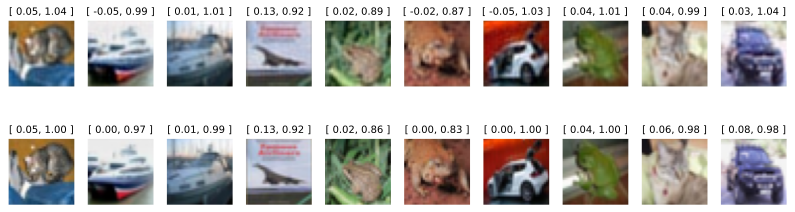

In [19]:
X,y = next(iter(test_loader))

# forward pass and loss
net.cpu()
net.eval() # switch to test mode
yHat = net(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')

  
plt.show()
